
# **Práctica 3: Transformers**

- Rubén Gil Martínez


### **Sesión 1/3: Preprocesamiento de secuencias de caracteres**


**CODIFICACIÓN.**

- Integer: se construye una tabla con todos los tokens considerados y se le asigna un índice entero a cada token. Luego a cada token de la secuencia se le asigna el índice correspondiente. Como las secuencias tienen tamaños diferentes, se suele configurar para que los vectores de salida tengan el tamaño de la secuencia más larga asignándose un 0 a los valores de relleno (*padding*).

- Multi-hot: la codificación de salida es un vector binario cuyo tamaño es el número de tokens considerados, si un token aparece en la secuencia codificada el vector tendrá un 1 en la posición correspondiente a ese token, si no un 0. Independientemente del tamaño de la secuencia a codificar, la salida será un vector cuyo tamaño se corresponde con la longitud del vocabulario. # |V| TAMAÑO DEL VECTOR PARA CADA TOKEN

- TF-IDF: es una extensión de multi-hot que en lugar de valores binarios asigna la frecuencia de aparición de un token en un conjunto de datos.


---


La librería Keras proporciona la clase [TextVectorization](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization/) que implementa una capa para la codificación de texto.

### El problema: clasificación de péptidos
<a class='anchor' id='problema'></a>

Durante esta práctica abordaremos el problema de la clasificación de fragmentos de texto. En concreto, nos centraremos en la clasificación de péptidos, secuencias de AAs, codificadas mediante caracteres de texto. Los péptidos se pueden agrupar en dos clases según presenten o no actividad antimicrobiana (AMP). Los CSV de entrada están separados entre los AMP y los no AMP, así que deberán fusionarse para construir un dataset que permita un entrenamiento supervisado.

En las diferentes sesiones de esta práctica construiremos diferentes modelos para resolver este problema. El punto de partida será la arquitectura genérica MLP, utilizaremos también redes neuronales recurrentes (RNN) para estudiar la ventaja de procesar datos en forma de secuencia y finalmente implementaremos un Transformer que se ha convertido en el modelo de referencia para este tipo de datos.




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras import layers, Sequential, optimizers
# CONJUNTO DE ENTRENAMIENTO DE LA CODIFICACIÓN: TODOS LAS CADENAS DE AMINOACIDOS, UTILIZAR ADAPT Y EMPLEAR PARA CODIFICAR CORRECTAMENTE CADA CARÁCTER DENTRO DE LA CADENA

**E1:** Carga las tablas almacenadas en los CSV utilizando la librería Pandas y fusiónalas en un solo Dataframe. Después construye una lista con todos los péptidos y otra cuyos elementos sean booleanos identificando si son AMP. ¿Cuál es la secuencia más larga? ¿Cuántos AAs diferentes hay? ¿Cuál es el vocabulario del lenguaje?

In [2]:
# Cargamos los datasets de péptidos antimicrobianos y péptidos sin efecto antimicrobiano en dataframes
peptidos_AM = pd.read_csv('../data/dataset_p3/veltri_dramp_cdhit_90.csv', sep=',')
perptidos_sin_efecto_AM =  pd.read_csv('../data/dataset_p3/non_amp_ampep_cdhit90.csv', sep=',')



# Fusionamos los dataframes para tener todos los péptidos en un único dataframe
peptidos = pd.concat([peptidos_AM, perptidos_sin_efecto_AM], ignore_index=True)



# Preprocesamiento y preparación de las cadenas de aminoácidos para su posterior codificación
# Eliminación de columnas innecesarias y conversión de las secuencias de aminoácidos a mayúsculas
peptidos.drop(columns=['Unnamed: 0'], inplace=True)
peptidos['aa_seq'] = peptidos['aa_seq'].str.upper()



# Listas con todos los péptidos y su respectiva clasificación
PEPTIDOS =list(peptidos['aa_seq'])
AMP = list(peptidos['AMP'])



# Análisis de los péptidos
print(f"Secuencia de aminoácidos más larga: {PEPTIDOS[np.argmax(peptidos['aa_len'])]}")
AAs = "".join(set("".join(PEPTIDOS)))
print(f"Número de aminoácidos diferentes: {len(AAs)}")
print(f"Vocabulario de aminoácidos: {sorted(AAs)}")

Secuencia de aminoácidos más larga: LGKFSQTCYNSAIQGSVLTSTCERTNGGYNTSSIDLNSVIENVDGSLKWQPSNFIETCRNTQLAGSSELAAECKTRAQQFVSTKINLDDHIANIDGTLKYE
Número de aminoácidos diferentes: 25
Vocabulario de aminoácidos: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


**E2:** Divide los conjuntos de datos del E1 en dos. Uno que contenga el 80% de las secuencias para el entrenamiento supervisado y otro que contenga al resto para testear los modelos entrenados. Asegúrate que en ambos conjuntos hay una selección representativos de péptidos.

**E3:** Codifica los péptidos empleando la codificación multi-hot. ¿Qué longitud tiene cada péptido codificado? **Cada péptido codificado tiene una longitud de 25, es decir, la longitud del vocabulario ya que se asocia un 1 en el índice del vector de codificación en caso de que el carácter asociado a ese índice aparezca en la secuencia y un 0 en caso contrario.**

**DIVISIÓN DEL DATASET EN ENTRENAMIENTO Y TEST (80/20):**

In [3]:
X_train, X_test, y_train, y_test = train_test_split(PEPTIDOS, AMP, test_size=0.2, random_state=76, stratify=AMP)

# Análisis de los péptidos para asegurarnos que se ha realizado una partición donde ambos conjuntos sean representativos
AAs_X_train = "".join(set("".join(X_train)))
AAs_X_test = "".join(set("".join(X_test)))


print(f"Número de aminoácidos diferentes Entrenamiento: {len(AAs_X_train)}")
print(f"Vocabulario de aminoácidos Entrenamiento: {sorted(AAs_X_train)}")
print(f"Número de aminoácidos diferentes Test: {len(AAs_X_test)}")
print(f"Vocabulario de aminoácidos Test: {sorted(AAs_X_test)}")
print()
print('Partición estratificada de los datos mediante la variable objetivo:')
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

Número de aminoácidos diferentes Entrenamiento: 25
Vocabulario de aminoácidos Entrenamiento: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Número de aminoácidos diferentes Test: 22
Vocabulario de aminoácidos Test: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X', 'Y']

Partición estratificada de los datos mediante la variable objetivo:
(array([False,  True]), array([1526, 1652]))
(array([False,  True]), array([382, 413]))


**CODIFICACIÓN MULTI-HOT DE LAS SECUENCIAS DE CARÁCTERES QUE REPRESENTAN A LOS PÉPTIDOS**

In [4]:
from keras.layers import TextVectorization

# Inicializar el vectorizador
vectorizer_hot = TextVectorization(
    max_tokens=25,  # Número de aminoácidos únicos
    output_mode='multi_hot',  # Modo de salida 
    standardize=None,  # No estandarizamos
    split='character'  # Dividimos por caracteres(aminoácidos)
)

# Ajustar el vectorizador a las secuencias, nos ajustamos solo al conjunto de entrenamiento para evitar la exposición a datos de test
vectorizer_hot.adapt(X_train)

# Transformamos los péptidos mediante la codificación multi-hot
X_train_encoded = vectorizer_hot(X_train)
X_test_encoded = vectorizer_hot(X_test)

In [5]:
peptidos['Multi-Hot'] = peptidos['aa_seq'].apply(lambda x: vectorizer_hot(x).numpy())

In [6]:
# Muestra de la correcta codificación de los péptidos 
peptidos.head(8)

,aa_seq,aa_len,AMP,Multi-Hot
0,GNGVLKTISHECNMNTWQFLFTCC,24,True,"[0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, ..."
1,TTKNYGNGVCNSVNWCQCGNVWASCNLATGCAAWLCKLA,39,True,"[0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, ..."
2,SNDSLWYGVGQFMGKQANCITNHPVKHMIIPGYCLSKILG,40,True,"[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, ..."
3,IAPIIVAGLGYLVKDAWDHSDQIISGFKKGWNGGRRK,37,True,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, ..."
4,FNRGGYNFGKSVRHVVDAIGSVAGIRGILKSIR,33,True,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, ..."
5,VFHAYSARGVRNNYKSAVGPADWVISAVRGFIHG,34,True,"[0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, ..."
6,RRSRKNGIGYAIGYAFGAVERAVLGGSRDYNK,32,True,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, ..."
7,KGLGKLIGIDWLLGQAKDAVKQYKKDYKRWH,31,True,"[0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ..."


In [7]:
# Vocabulario de codificación
vocab = vectorizer_hot.get_vocabulary()
char_indices = {char: idx for idx, char in enumerate(vocab)}
print("Vocabulario de carácteres e índices asociados a cada uno: \n " , char_indices, "\n")
print("Longitud de los péptidos codificados/longitud vectores multi-hot:", X_train_encoded.shape[1])


Vocabulario de carácteres e índices asociados a cada uno: 
  {'[UNK]': 0, np.str_('K'): 1, np.str_('L'): 2, np.str_('G'): 3, np.str_('A'): 4, np.str_('R'): 5, np.str_('S'): 6, np.str_('V'): 7, np.str_('I'): 8, np.str_('C'): 9, np.str_('E'): 10, np.str_('T'): 11, np.str_('P'): 12, np.str_('N'): 13, np.str_('F'): 14, np.str_('D'): 15, np.str_('Q'): 16, np.str_('Y'): 17, np.str_('M'): 18, np.str_('H'): 19, np.str_('W'): 20, np.str_('X'): 21, np.str_('U'): 22, np.str_('O'): 23, np.str_('Z'): 24} 

Longitud de los péptidos codificados/longitud vectores multi-hot: 25


**E4:** Basándote en la arquitectura del E4 de la Sesión 1 de la Práctica 2 (Redes Convolucionales), construye un MLP para clasificar los péptidos. ¿Cuántos parámetros a entrenar tiene? **Siguiendo la misma arquitectura, tenemos 185.857 parámetros entrenables.**

**E5:** Entrena el modelo del E4 utilizando el 20% de los datos de entrenamiento para validación durante el entrenamiento. Utiliza una cantidad de épocas que produzca sobreajuste, además añade un *callback* para guardar el modelo que tenga una mayor precisión en la validación.

**E6:** Testea la precisión del modelo entrenado en el E5 empleando el conjunto de test obtenido en el E2. Recuerda cargar el modelo para la mejor época. ¿Qué precisión se alcanza? **SE ALCANZA UNA PRECISIÓN DE 0.7371, NO ES MUY BUENA PERO CON LA IMPLEMENTACIÓN DE OTRAS CODIFICACIONES Y OTRAS ARQUITECTURAS QUE CAPTEN MEJOR EL CARÁCTER SECUENCIAL QUE PRESENTA ESTE PROBLEMA, CONSEGUIREMOS MEJORAR EN PRESTACIONES.**

In [8]:
# Definimos un earling stopping para detener el entrenamiento de los modelos cuando ya no mejoren la precisión de la validación
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Métrica a monitorear 
    patience=50,  # Número de epochs sin mejora antes de parar
    min_delta=0.0001,  # Pequeña mejora mínima requerida
    restore_best_weights=True,  # Restaura los mejores pesos en lugar de los últimos
    verbose=1  # Muestra mensaje en la consola con la época que contiene los mejores pesos
)

In [9]:
# Obtención del 20% de los datos de entrenamiento para validación del modelo durante el proceso de entrenamiento
X_train_f, X_val_f, y_train_f, y_val_f = train_test_split(np.array(X_train_encoded), y_train, test_size=0.2, random_state=2025, stratify=y_train)

In [10]:
# Conversión de las etiquetas a arrays de numpy para su uso en la red neuronal
y_train_f = np.array(y_train_f)
y_val_f = np.array(y_val_f)
y_test = np.array(y_test)

In [12]:
model = Sequential([ 
    layers.Input(shape=(X_train_f.shape[1],)),
    layers.Dense(512, activation='leaky_relu'),
    layers.Dense(256, activation='leaky_relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,857 (726.00 KB)

 Trainable params: 185,857 (726.00 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Compilación del modelo previa a entrenamiento
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
history = model.fit(X_train_f, y_train_f, epochs=150, batch_size=32, validation_data=(X_val_f, y_val_f), callbacks=[early_stopping])

Epoch 1/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5998 - loss: 0.6799 - val_accuracy: 0.6981 - val_loss: 0.6244
Epoch 2/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7206 - loss: 0.5956 - val_accuracy: 0.7107 - val_loss: 0.5717
Epoch 3/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7257 - loss: 0.5423 - val_accuracy: 0.7107 - val_loss: 0.5641
Epoch 4/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7277 - loss: 0.5312 - val_accuracy: 0.7170 - val_loss: 0.5573
Epoch 5/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7295 - loss: 0.5387 - val_accuracy: 0.7154 - val_loss: 0.5555
Epoch 6/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7332 - loss: 0.5198 - val_accuracy: 0.7233 - val_loss: 0.5480
Epoch 7/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7579 - loss: 0.4959 - val_accuracy: 0.7248 - val_loss: 0.5407
Epoch 8/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7427 - loss: 0.5060 - val_accuracy: 0.7186 - v

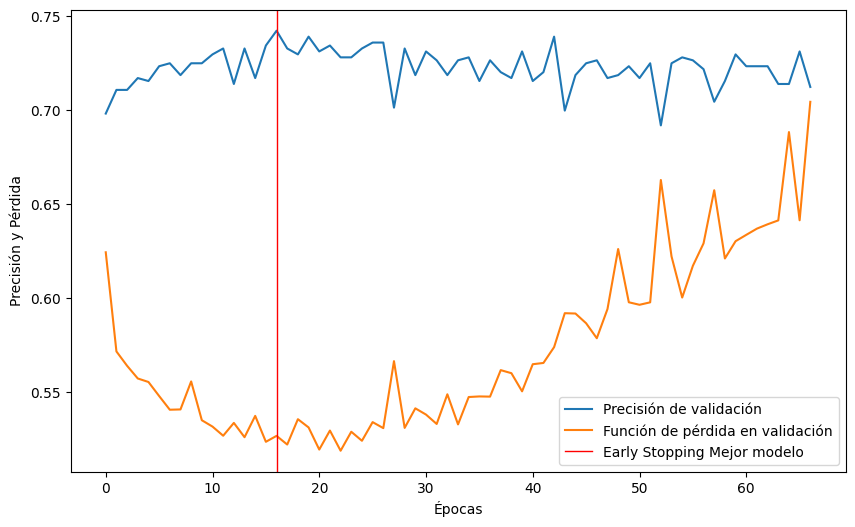

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.plot(history.history['val_loss'], label= 'Función de pérdida en validación')

plt.axvline(x=np.argmax(history.history['val_accuracy']), color='r', linestyle='-', linewidth=1, label='Early Stopping Mejor modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión y Pérdida')
plt.legend()
plt.show()

**PODEMOS OBSERVAR EN LA SIGUIENTE GRÁFICA COMO SE SELECCIONA EL MODELO DE MAYOR PRECISIÓN A PARTIR DEL EARLY STOPPING PREVIAMENTE DEFINIDO, OBSERVAR QUE EL INCREMENTO DE LA FUNCIÓN DE PÉRDIDA EN VALIDACIÓN ES UNA CLARA SEÑAL DEL SOBREAJUSTE DEL MODELO.**

In [15]:
# Testeo, predicción y evaluación del modelo
test_loss, test_acc = model.evaluate(X_test_encoded, y_test)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7032 - loss: 0.5216 
Test Accuracy: 0.7371069192886353
Test Loss: 0.5025330185890198


In [16]:
predictions = model.predict(X_test_encoded[0:10])
predictions = np.where(predictions > 0.5, True, False)
print(f"Predicciones del modelo:  {predictions.T}")
print(f"Clases reales: {y_test[0:10]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Predicciones del modelo:  [[ True  True  True  True False  True  True  True  True False]]
Clases reales: [ True False  True  True False  True False  True False False]


**E7:** Repite los ejercicios E3-6 pero esta vez empleando codificación TF-IDF. ¿Ha mejorado la precisión? ¿por qué?

**SE ALCANZA UNA PRECISIÓN DE 0.8275, SE CONSIGUE UNA CONSIDERABLE MEJORA EN LA PRECISIÓN.**
**ESTA SE DA POR EL CAMBIO DE CODIFICACIÓN REALIZADO, CON TF-IDF BRINDAMOS A LA RED DE MUCHA MÁS INFORMACIÓN SOBRE LA DISTRIBUCIÓN/APARICIÓN DE LOS AMINOÁCIDOS EN LOS DISTINTOS PÉPTIDOS, COMO POSTERIORMENTE SERÁ COMENTADO, ESTA CODIFICACIÓN BRINDA LA SIGUIENTE INFORMACIÓN A NIVEL DE AMINOÁCIDO:** 

- NÚMERO DE VECES QUE APARECE EN EL PROPIO PÉPTIDO
- IMPORTANCIA DE ESTE MEDIDA A PARTIR DE LA CANTIDAD DE PÉPTIDOS EN LOS QUE APARECE


In [11]:
# Inicializar el vectorizador
vectorizer = TextVectorization(
    max_tokens=25,  # Número de aminoácidos únicos
    output_mode='tf-idf',  # Modo de salida 
    standardize=None,  # No estandarizamos
    split='character'  # Dividimos por caracteres(aminoácidos)
)

# Ajustar el vectorizador a las secuencias, nos ajustamos solo al conjunto de entrenamiento para evitar la exposición a datos de test
vectorizer.adapt(X_train)

# Transformamos los péptidos mediante la codificación TF-IDF
X_train_encoded = vectorizer(X_train)
X_test_encoded = vectorizer(X_test)

In [12]:
peptidos['TF-IDF'] = peptidos['aa_seq'].apply(lambda x: vectorizer(x).numpy())

In [13]:
# Mostramos la correcta codificación de los péptidos mediante TF-IDF
peptidos.head(8)

,aa_seq,aa_len,AMP,Multi-Hot,TF-IDF
0,GNGVLKTISHECNMNTWQFLFTCC,24,True,"[0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, ...","[0.0, 0.79246056, 1.5467752, 1.56601, 0.0, 0.0..."
1,TTKNYGNGVCNSVNWCQCGNVWASCNLATGCAAWLCKLA,39,True,"[0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0.0, 1.5849211, 2.3201628, 3.13202, 4.0539956..."
2,SNDSLWYGVGQFMGKQANCITNHPVKHMIIPGYCLSKILG,40,True,"[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[0.0, 2.3773818, 2.3201628, 3.915025, 0.810799..."
3,IAPIIVAGLGYLVKDAWDHSDQIISGFKKGWNGGRRK,37,True,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, ...","[0.0, 3.1698422, 1.5467752, 4.69803, 2.4323974..."
4,FNRGGYNFGKSVRHVVDAIGSVAGIRGILKSIR,33,True,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, ...","[0.0, 1.5849211, 0.7733876, 4.69803, 1.6215982..."
5,VFHAYSARGVRNNYKSAVGPADWVISAVRGFIHG,34,True,"[0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, ...","[0.0, 0.79246056, 0.0, 3.13202, 4.0539956, 2.6..."
6,RRSRKNGIGYAIGYAFGAVERAVLGGSRDYNK,32,True,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, ...","[0.0, 1.5849211, 0.7733876, 4.69803, 3.2431965..."
7,KGLGKLIGIDWLLGQAKDAVKQYKKDYKRWH,31,True,"[0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 5.547224, 3.0935504, 3.13202, 1.6215982,..."


In [14]:
# Vocabulario de codificación
vocab = vectorizer.get_vocabulary()
char_indices = {char: idx for idx, char in enumerate(vocab)}
print("Vocabulario de carácteres e índices asociados a cada uno: \n " , char_indices, "\n")
print("Longitud de los péptidos codificados/longitud vectores multi-hot:", X_train_encoded.shape[1])

Vocabulario de carácteres e índices asociados a cada uno: 
  {'[UNK]': 0, np.str_('K'): 1, np.str_('L'): 2, np.str_('G'): 3, np.str_('A'): 4, np.str_('R'): 5, np.str_('S'): 6, np.str_('V'): 7, np.str_('I'): 8, np.str_('C'): 9, np.str_('E'): 10, np.str_('T'): 11, np.str_('P'): 12, np.str_('N'): 13, np.str_('F'): 14, np.str_('D'): 15, np.str_('Q'): 16, np.str_('Y'): 17, np.str_('M'): 18, np.str_('H'): 19, np.str_('W'): 20, np.str_('X'): 21, np.str_('U'): 22, np.str_('O'): 23, np.str_('Z'): 24} 

Longitud de los péptidos codificados/longitud vectores multi-hot: 25


**Cada péptido codificado sigue teniendo una longitud de 25, es decir, la longitud del vocabulario de aminoácidos pero en este caso no realizamos una codificación binaria sino que seguimos el modelo de codificación basado en la normalización por frecuencia de token(aminoácido) en el propio péptido junto a la frecuencia de aparición de este en las diversas muestras de péptidos.**

La frecuencia de término mide cuántas veces aparece un token en un péptido, se usa la variante logarítmica para evitar que los aminoácidos muy frecuentes dominen.

$$
TF(t, d) = 1 + \log_{10} (f_{t,d}) \quad \text{si } f_{t,d} > 0
$$

Si el token **no aparece** en el péptido, se define como:

$$
TF(t, d) = 0 \quad \text{si } f_{t,d} = 0
$$

---
La **IDF** mide la importancia de un aminoácido considerando en cuántos péptidos aparece, si aparece en todos su importancia se reduce pero si no es my frecuente puede ser que le de a la red información fundamental para tomar una decisión:


$$
IDF(t) = \log \left( \frac{N}{DF_t + 1} \right)
$$


---

**Cálculo del TF-IDF**

El **TF-IDF** se calcula multiplicando **TF** por **IDF**:

$$
TF\text{-}IDF(t, d) = TF(t, d) \times IDF(t)
$$

Así es como se obtiene la codificación de cada aminoácido de los diferentes péptidos del conjunto de datos.


In [15]:
# Obtención del 20% de los datos de entrenamiento para validación del modelo durante el proceso de entrenamiento
X_train_f, X_val_f, y_train_f, y_val_f = train_test_split(np.array(X_train_encoded), y_train, test_size=0.2, random_state=2025, stratify=y_train)

# Conversión de las etiquetas a arrays de numpy para su uso en la red neuronal
y_train_f = np.array(y_train_f)
y_val_f = np.array(y_val_f)
y_test = np.array(y_test)

In [22]:
model_tfidf = Sequential([ 
    layers.Input(shape=(X_train_f.shape[1],)),
    layers.Dense(512, activation='leaky_relu'),
    layers.Dense(256, activation='leaky_relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')])

model_tfidf.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 512)            │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,857 (726.00 KB)

 Trainable params: 185,857 (726.00 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Compilación del modelo previa a entrenamiento
model_tfidf.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
history = model_tfidf.fit(X_train_f, y_train_f, epochs=150, batch_size=32, validation_data=(X_val_f, y_val_f), callbacks=[early_stopping])

Epoch 1/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6453 - loss: 0.6363 - val_accuracy: 0.7516 - val_loss: 0.5348
Epoch 2/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7735 - loss: 0.5307 - val_accuracy: 0.7673 - val_loss: 0.5002
Epoch 3/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7946 - loss: 0.4636 - val_accuracy: 0.7783 - val_loss: 0.4763
Epoch 4/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8130 - loss: 0.4385 - val_accuracy: 0.7909 - val_loss: 0.4506
Epoch 5/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8180 - loss: 0.4204 - val_accuracy: 0.7956 - val_loss: 0.4445
Epoch 6/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8138 - loss: 0.4175 - val_accuracy: 0.8066 - val_loss: 0.4297
Epoch 7/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8271 - loss: 0.3923 - val_accuracy: 0.8019 - val_loss: 0.4330
Epoch 8/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8285 - loss: 0.3837 - val_accuracy: 0.8082 - v

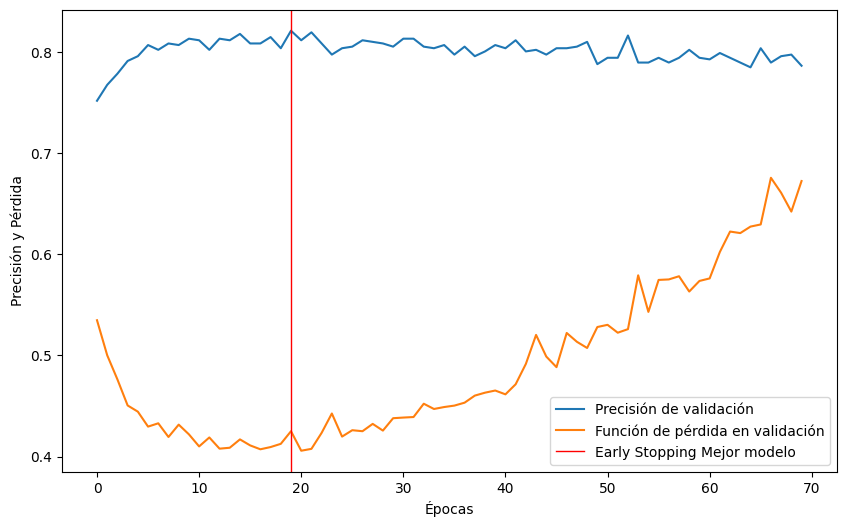

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.plot(history.history['val_loss'], label= 'Función de pérdida en validación')

plt.axvline(x=np.argmax(history.history['val_accuracy']), color='r', linestyle='-', linewidth=1, label='Early Stopping Mejor modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión y Pérdida')
plt.legend()
plt.show()

In [25]:
# Testeo, predicción y evaluación del modelo
test_loss, test_acc = model_tfidf.evaluate(X_test_encoded, y_test)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8036 - loss: 0.4366 
Test Accuracy: 0.8201257586479187
Test Loss: 0.42888280749320984


**E8:** Hasta ahora hemos trabajado solo con unigramas, los tokens están compuesto por AAs aislados. También es posible construir tokens con combinaciones de AAs (n-gramas). Repite el ejercicio E7 pero esta vez empleando bigramas. ¿Qué tamaño tiene el vocabulario ahora? ¿Por qué MLP ha aumentado considerablemente el número de parámetros a entrenar? ¿Qué ventaja podría aportar el trabajar con n-gramas (n > 1) en comparación de unigramas?

**Ahora el vocabulario tiene un tamaño de 486 tokens diferentes, a los 25 únicos se les añade todas las distintas combinaciones de parejas de aminoácidos.**

**Porque ahora, la entrada del modelo no es un vector de tamaño 25, sino que se da un input mucho mayor, esto lleva a que en la primera capa del modelo hayan muchos más parámetros a ajustar. Se puede observar claramente en el resumen de la construcción de la arquitectura, en los modelos anteriores la primera capa contiene 13.312 parámetros entrenables y este nuevo modelo contiene 249.344 parámetros entrenable solamente en la primera capa.**

**El uso de bigramas nos podría ayudar a mejorar la precisión del modelo ya que este va a ser capaz de capturar:**
- Interacciones locales entre residuos
- Información primordial que proporcionan parejas de aminoácidos sobre la función biológica del péptido
- Similitudes en secuencias cortas

In [16]:
# Inicializar el vectorizador
vectorizer = TextVectorization(
    max_tokens=None,  # Número de aminoácidos únicos
    output_mode='tf-idf',  # Modo de salida 
    standardize=None,  # No estandarizamos
    split='character',  # Dividimos por caracteres(aminoácidos)
    ngrams=(1, 2)  # Incluimos n-gramas de 1 y 2 caracteres
)

# Ajustar el vectorizador a las secuencias, nos ajustamos solo al conjunto de entrenamiento para evitar la exposición a datos de test
vectorizer.adapt(X_train)

# Transformamos los péptidos mediante la codificación TF-IDF con el uso de bigramas
X_train_encoded = vectorizer(X_train)
X_test_encoded = vectorizer(X_test)

In [17]:
peptidos['TF-IDF_with_bigrams'] = peptidos['aa_seq'].apply(lambda x: vectorizer(x).numpy())
peptidos.head(8)

,aa_seq,aa_len,AMP,Multi-Hot,TF-IDF,TF-IDF_with_bigrams
0,GNGVLKTISHECNMNTWQFLFTCC,24,True,"[0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, ...","[0.0, 0.79246056, 1.5467752, 1.56601, 0.0, 0.0...","[0.0, 0.79246056, 1.5467752, 1.56601, 0.0, 0.0..."
1,TTKNYGNGVCNSVNWCQCGNVWASCNLATGCAAWLCKLA,39,True,"[0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0.0, 1.5849211, 2.3201628, 3.13202, 4.0539956...","[0.0, 1.5849211, 2.3201628, 3.13202, 4.0539956..."
2,SNDSLWYGVGQFMGKQANCITNHPVKHMIIPGYCLSKILG,40,True,"[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[0.0, 2.3773818, 2.3201628, 3.915025, 0.810799...","[0.0, 2.3773818, 2.3201628, 3.915025, 0.810799..."
3,IAPIIVAGLGYLVKDAWDHSDQIISGFKKGWNGGRRK,37,True,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, ...","[0.0, 3.1698422, 1.5467752, 4.69803, 2.4323974...","[0.0, 3.1698422, 1.5467752, 4.69803, 2.4323974..."
4,FNRGGYNFGKSVRHVVDAIGSVAGIRGILKSIR,33,True,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, ...","[0.0, 1.5849211, 0.7733876, 4.69803, 1.6215982...","[0.0, 1.5849211, 0.7733876, 4.69803, 1.6215982..."
5,VFHAYSARGVRNNYKSAVGPADWVISAVRGFIHG,34,True,"[0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, ...","[0.0, 0.79246056, 0.0, 3.13202, 4.0539956, 2.6...","[0.0, 0.79246056, 0.0, 3.13202, 4.0539956, 2.6..."
6,RRSRKNGIGYAIGYAFGAVERAVLGGSRDYNK,32,True,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, ...","[0.0, 1.5849211, 0.7733876, 4.69803, 3.2431965...","[0.0, 1.5849211, 0.7733876, 4.69803, 3.2431965..."
7,KGLGKLIGIDWLLGQAKDAVKQYKKDYKRWH,31,True,"[0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 5.547224, 3.0935504, 3.13202, 1.6215982,...","[0.0, 5.547224, 3.0935504, 3.13202, 1.6215982,..."


In [18]:
vocab = vectorizer.get_vocabulary()
char_indices = {char: idx for idx, char in enumerate(vocab)}
print("Vocabulario de carácteres e índices asociados a cada uno: \n " , char_indices, "\n")
print("Longitud de los péptidos codificados/longitud vectores multi-hot:", X_train_encoded.shape[1])

Vocabulario de carácteres e índices asociados a cada uno: 
  {'[UNK]': 0, np.str_('K'): 1, np.str_('L'): 2, np.str_('G'): 3, np.str_('A'): 4, np.str_('R'): 5, np.str_('S'): 6, np.str_('V'): 7, np.str_('I'): 8, np.str_('C'): 9, np.str_('E'): 10, np.str_('T'): 11, np.str_('P'): 12, np.str_('N'): 13, np.str_('F'): 14, np.str_('D'): 15, np.str_('Q'): 16, np.str_('Y'): 17, np.str_('M'): 18, np.str_('H'): 19, np.str_('W'): 20, np.str_('K K'): 21, np.str_('R R'): 22, np.str_('L L'): 23, np.str_('G G'): 24, np.str_('L K'): 25, np.str_('A A'): 26, np.str_('A K'): 27, np.str_('K L'): 28, np.str_('G K'): 29, np.str_('G L'): 30, np.str_('L A'): 31, np.str_('L G'): 32, np.str_('K R'): 33, np.str_('A L'): 34, np.str_('K A'): 35, np.str_('K G'): 36, np.str_('K I'): 37, np.str_('S L'): 38, np.str_('L S'): 39, np.str_('A G'): 40, np.str_('R K'): 41, np.str_('S G'): 42, np.str_('V L'): 43, np.str_('V K'): 44, np.str_('I K'): 45, np.str_('F L'): 46, np.str_('K V'): 47, np.str_('R L'): 48, np.str_('I L'):

In [19]:
# Obtención del 20% de los datos de entrenamiento para validación del modelo durante el proceso de entrenamiento
X_train_f, X_val_f, y_train_f, y_val_f = train_test_split(np.array(X_train_encoded), y_train, test_size=0.2, random_state=2025, stratify=y_train)

# Conversión de las etiquetas a arrays de numpy para su uso en la red neuronal
y_train_f = np.array(y_train_f)
y_val_f = np.array(y_val_f)
y_test = np.array(y_test)

In [30]:
# Definimos un earling stopping para detener el entrenamiento de los modelos cuando ya no mejoren la precisión de la validación
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Métrica a monitorear 
    patience=80,  # Número de epochs sin mejora antes de parar
    min_delta=0.00001,  # Pequeña mejora mínima requerida
    restore_best_weights=True,  # Restaura los mejores pesos en lugar de los últimos
    verbose=1  # Muestra mensaje en la consola con la época que contiene los mejores pesos
)

In [31]:
model_tfidf_bigram = Sequential([ 
    layers.Input(shape=(X_train_f.shape[1],)),
    layers.Dense(512, activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.Dense(256, activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.Dense(64, activation='leaky_relu'),
    layers.Dense(1, activation='sigmoid')])
model_tfidf_bigram.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 512)            │       249,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 425,473 (1.62 MB)

 Trainable params: 423,681 (1.62 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [32]:
# Compilación del modelo previa a entrenamiento
model_tfidf_bigram.compile(optimizer=optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
history = model_tfidf_bigram.fit(X_train_f, y_train_f, epochs=200, batch_size=64, validation_data=(X_val_f, y_val_f), callbacks=[early_stopping])

Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4782 - loss: 0.8344 - val_accuracy: 0.5157 - val_loss: 0.7193
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5355 - loss: 0.7649 - val_accuracy: 0.5660 - val_loss: 0.6799
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5725 - loss: 0.6976 - val_accuracy: 0.5943 - val_loss: 0.6494
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6347 - loss: 0.6482 - val_accuracy: 0.6179 - val_loss: 0.6276
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6612 - loss: 0.6123 - val_accuracy: 0.6289 - val_loss: 0.6087
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6847 - loss: 0.5757 - val_accuracy: 0.6541 - val_loss: 0.5929
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7017 - loss: 0.5763 - val_accuracy: 0.6777 - val_loss: 0.5792
Epoch 8/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7192 - loss: 0.5486 - val_accuracy: 0.6934 - 

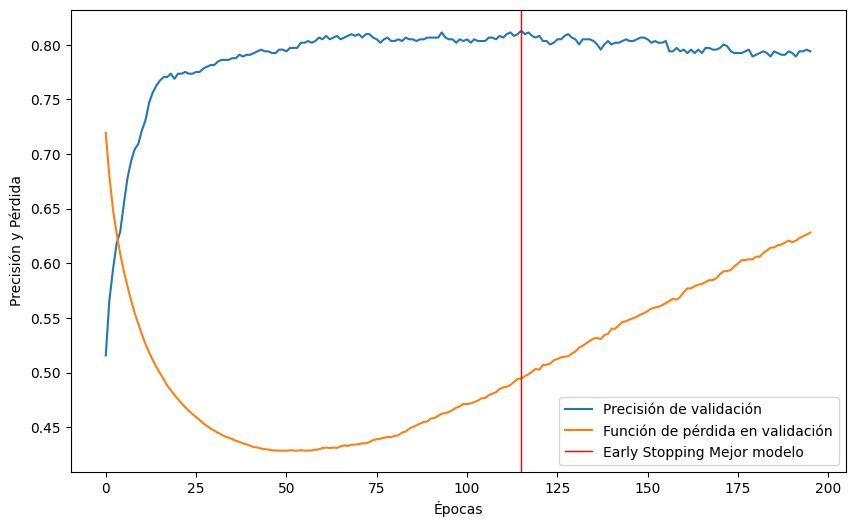

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.plot(history.history['val_loss'], label= 'Función de pérdida en validación')

plt.axvline(x=np.argmax(history.history['val_accuracy']), color='r', linestyle='-', linewidth=1, label='Early Stopping Mejor modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión y Pérdida')
plt.legend()
plt.show()

In [34]:
# Testeo, predicción y evaluación del modelo
test_loss, test_acc = model_tfidf_bigram.evaluate(X_test_encoded, y_test)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8082 - loss: 0.4876
Test Accuracy: 0.800000011920929
Test Loss: 0.495034396648407


### **Sesión 2/3: Redes recurrentes y embedding**

**E1:** Codifica el dataset de la Sesión 1 utilizando esta vez una codificación de tipo *integer*.

**E2:** Construye un modelo LSTM bidireccional con 50 células LSTM, entrénalo empleando el resultado de E1 y evalúa la precisión del modelo entrenado. Para el entrenamiento utiliza la aproximación empleada para los ejercicios de la Sesión 1.

**Codificación tipo integer**

In [ ]:
vectorizer = TextVectorization(
    max_tokens=None,  # Número de aminoácidos únicos -> Lo ponemos a None para poder tratar también con los carácteres de padding y de UNK
    output_mode='int',
    standardize=None,  # No estandarizamos
    split='character'  # Dividimos por caracteres(aminoácidos)
)

# Ajustar el vectorizador a las secuencias, nos ajustamos solo al conjunto de entrenamiento para evitar la exposición a datos de test
vectorizer.adapt(X_train)

# Transformamos los péptidos mediante la codificación integer
X_train_encoded = vectorizer(X_train)
X_test_encoded = vectorizer(X_test)

# Almacenamos la codificación de los péptidos en integer
peptidos['Integer'] = peptidos['aa_seq'].apply(lambda x: vectorizer(x).numpy())


In [84]:
print('Nº de tokens distintos a procesar:', len(vectorizer.get_vocabulary()))
for index, token in enumerate(vectorizer.get_vocabulary()):
    print(f"Token: {token}, Index: {index}")

Nº de tokens distintos a procesar: 27
Token: , Index: 0
Token: [UNK], Index: 1
Token: K, Index: 2
Token: L, Index: 3
Token: G, Index: 4
Token: A, Index: 5
Token: R, Index: 6
Token: S, Index: 7
Token: V, Index: 8
Token: I, Index: 9
Token: C, Index: 10
Token: E, Index: 11
Token: T, Index: 12
Token: P, Index: 13
Token: N, Index: 14
Token: F, Index: 15
Token: D, Index: 16
Token: Q, Index: 17
Token: Y, Index: 18
Token: M, Index: 19
Token: H, Index: 20
Token: W, Index: 21
Token: X, Index: 22
Token: U, Index: 23
Token: O, Index: 24
Token: Z, Index: 25
Token: B, Index: 26


In [85]:
peptidos.head(8)

,aa_seq,aa_len,AMP,Multi-Hot,TF-IDF,TF-IDF_with_bigrams,Integer
0,GNGVLKTISHECNMNTWQFLFTCC,24,True,"[0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, ...","[0.0, 0.79246056, 1.5467752, 1.56601, 0.0, 0.0...","[0.0, 0.79246056, 1.5467752, 1.56601, 0.0, 0.0...","[4, 14, 4, 8, 3, 2, 12, 9, 7, 20, 11, 10, 14, ..."
1,TTKNYGNGVCNSVNWCQCGNVWASCNLATGCAAWLCKLA,39,True,"[0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0.0, 1.5849211, 2.3201628, 3.13202, 4.0539956...","[0.0, 1.5849211, 2.3201628, 3.13202, 4.0539956...","[12, 12, 2, 14, 18, 4, 14, 4, 8, 10, 14, 7, 8,..."
2,SNDSLWYGVGQFMGKQANCITNHPVKHMIIPGYCLSKILG,40,True,"[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[0.0, 2.3773818, 2.3201628, 3.915025, 0.810799...","[0.0, 2.3773818, 2.3201628, 3.915025, 0.810799...","[7, 14, 16, 7, 3, 21, 18, 4, 8, 4, 17, 15, 19,..."
3,IAPIIVAGLGYLVKDAWDHSDQIISGFKKGWNGGRRK,37,True,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, ...","[0.0, 3.1698422, 1.5467752, 4.69803, 2.4323974...","[0.0, 3.1698422, 1.5467752, 4.69803, 2.4323974...","[9, 5, 13, 9, 9, 8, 5, 4, 3, 4, 18, 3, 8, 2, 1..."
4,FNRGGYNFGKSVRHVVDAIGSVAGIRGILKSIR,33,True,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, ...","[0.0, 1.5849211, 0.7733876, 4.69803, 1.6215982...","[0.0, 1.5849211, 0.7733876, 4.69803, 1.6215982...","[15, 14, 6, 4, 4, 18, 14, 15, 4, 2, 7, 8, 6, 2..."
5,VFHAYSARGVRNNYKSAVGPADWVISAVRGFIHG,34,True,"[0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, ...","[0.0, 0.79246056, 0.0, 3.13202, 4.0539956, 2.6...","[0.0, 0.79246056, 0.0, 3.13202, 4.0539956, 2.6...","[8, 15, 20, 5, 18, 7, 5, 6, 4, 8, 6, 14, 14, 1..."
6,RRSRKNGIGYAIGYAFGAVERAVLGGSRDYNK,32,True,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, ...","[0.0, 1.5849211, 0.7733876, 4.69803, 3.2431965...","[0.0, 1.5849211, 0.7733876, 4.69803, 3.2431965...","[6, 6, 7, 6, 2, 14, 4, 9, 4, 18, 5, 9, 4, 18, ..."
7,KGLGKLIGIDWLLGQAKDAVKQYKKDYKRWH,31,True,"[0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 5.547224, 3.0935504, 3.13202, 1.6215982,...","[0.0, 5.547224, 3.0935504, 3.13202, 1.6215982,...","[2, 4, 3, 4, 2, 3, 9, 4, 9, 16, 21, 3, 3, 4, 1..."


- **Usaremos pad_sequences() para unificar la longitud de las secuencias**

- **Usaremos Bidirectional(LSTM(...)) para que la red procese la secuencia en ambas direcciones. Esto es importante ya que los aminoácidos mantienen relaciones en ambas direcciones.**

In [86]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding

In [87]:
max_len = max(len(seq) for seq in X_train)  # Longitud máxima de las secuencias de péptidos

# Aplicamos padding para unificar la longitud de las secuencias
X_train_padded = pad_sequences(X_train_encoded, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_encoded, maxlen=max_len, padding='post')


In [88]:
# Construcción del modelo
model_int_LSTM = Sequential([
    layers.Input(shape=(max_len, 1)),  
    Bidirectional(LSTM(50, return_sequences=False)),  # LSTM bidireccional con 50 células
    Dense(64, activation='relu'),  # Capa oculta con 64 neuronas
    Dense(1, activation='sigmoid')  
])

# Resumen del modelo
model_int_LSTM.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 100)            │        20,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,329 (106.75 KB)

 Trainable params: 27,329 (106.75 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
# Obtención del 20% de los datos de entrenamiento para validación del modelo durante el proceso de entrenamiento
X_train_f, X_val_f, y_train_f, y_val_f = train_test_split(np.array(X_train_padded), y_train, test_size=0.2, random_state=2025, stratify=y_train)

# Conversión de las etiquetas a arrays de numpy para su uso en la red neuronal
y_train_f = np.array(y_train_f)
y_val_f = np.array(y_val_f)
y_test = np.array(y_test)

In [90]:
print(X_train_f[0]) # Se puede observar el padding de ceros en una muestra

[ 6  4  3 21  7  2  9  2 11  5  4  2  5  5  3 12  5  5  4  2  5  5  3  4
  5  8  7 16  5  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0]


In [91]:
# Definimos un earling stopping para detener el entrenamiento de los modelos cuando ya no mejoren la precisión de la validación
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Métrica a monitorear 
    patience=50,  # Número de epochs sin mejora antes de parar
    min_delta=0.0001,  # Pequeña mejora mínima requerida
    restore_best_weights=True,  # Restaura los mejores pesos en lugar de los últimos
    verbose=1  # Muestra mensaje en la consola con la época que contiene los mejores pesos
)

In [92]:
# Compilamos el modelo
model_int_LSTM.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Enntrenamos el modelo
history = model_int_LSTM.fit(X_train_f, y_train_f, epochs=100, batch_size=32, validation_data=(X_val_f, y_val_f), callbacks=[early_stopping])

Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.6023 - loss: 0.6675 - val_accuracy: 0.6651 - val_loss: 0.6277
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.6197 - loss: 0.6476 - val_accuracy: 0.6698 - val_loss: 0.6227
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.6338 - loss: 0.6383 - val_accuracy: 0.6808 - val_loss: 0.6069
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.6322 - loss: 0.6277 - val_accuracy: 0.6840 - val_loss: 0.5987
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6339 - loss: 0.6308 - val_accuracy: 0.6981 - val_loss: 0.5880
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6502 - loss: 0.6162 - val_accuracy: 0.7264 - val_loss: 0.5770
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7006 - loss: 0.5916 - val_accuracy: 0.7296 - val_loss: 0.5669
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6798 - loss: 0.5997 - val_accuracy: 0.

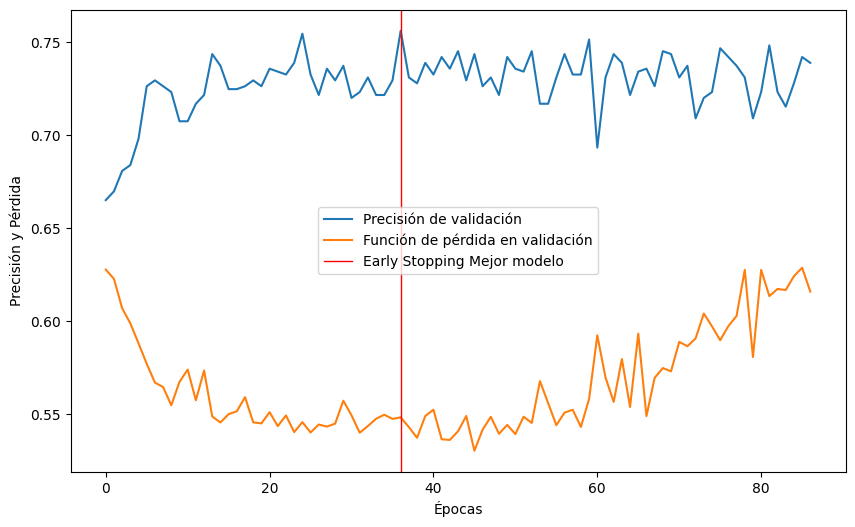

In [93]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.plot(history.history['val_loss'], label= 'Función de pérdida en validación')
plt.axvline(x=np.argmax(history.history['val_accuracy']), color='r', linestyle='-', linewidth=1, label='Early Stopping Mejor modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión y Pérdida')
plt.legend()
plt.show()

In [94]:
# Testeo, predicción y evaluación del modelo
test_loss, test_acc = model_int_LSTM.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7328 - loss: 0.5387
Test Accuracy: 0.7270440459251404
Test Loss: 0.5528684258460999


**El modelo con arquitectura LSTM y codificación Integer clasifica correctamente el 72.7% - 73.28% de los ejemplos de prueba.**

**E3:** Repite el ejercicio anterior, pero utilizando una codificación *one-hot*. ¿Qué ventaja ofrece la codificación *one-hot* sobre *integer*? ¿Se podría utilizar la codificación *one-hot* para procesar lenguaje natural? ¿por qué?

- **La principal ventaja que ofrece one-hot sobre integer es el hecho de que su tipo de codificación proporciona un tamaño de vector igual para todos los péptidos mientras que con la codificación integer eso no ocurre y tenemos que aplicar un padding previo para que todos los vectores de los péptidos tengan el mismo tamaño.**


**Como poder, se pueder utilizar, pero es mejor no utilizarla por diversos motivos:**
- 1) En el entrenamiento con corpus de muchos tokens distintos, tamaño del vocabulario gigante, tendremos unos vectores muy dispersos y con una dimensionalidad muy elevada.

- 2) Esa representación vectorial no permite codificar ningún tipo de información sintáctica o semántica, todos los tokens se encuentran a la misma distancia entre sí mientras que, como bien sabemos, en el lenguaje hay palabras que se parecen más y otras que se parecen menos, entonces, tendrá todo el sentido que los vectores de aquellos tokens similares se encuentren cerca en el espacio vectorial.

Esta capacidad de codificar la información semántica intrínseca de cada token en los vectores llega con los embeddings, vectores densos que se construyen utilizando el contexto que proporcionan los tokens previos y posteriores al token a codificar. Proporcionan una representación mucho más informativa de cada uno de los tokens y con la ventaja de reducir considerablemente las dimensiones de los vectores.

In [95]:
# Codificación Multi-hot para el modelo LSTM
X_train_encoded = vectorizer_hot(X_train)
X_test_encoded = vectorizer_hot(X_test)

# Obtención del 20% de los datos de entrenamiento para validación del modelo durante el proceso de entrenamiento
X_train_f, X_val_f, y_train_f, y_val_f = train_test_split(np.array(X_train_encoded), y_train, test_size=0.2, random_state=2025, stratify=y_train)

# Conversión de las etiquetas a arrays de numpy para su uso en la red neuronal
y_train_f = np.array(y_train_f)
y_val_f = np.array(y_val_f)
y_test = np.array(y_test)

In [96]:
print('Tamaño del vocabulario:', len(vectorizer_hot.get_vocabulary()))

Tamaño del vocabulario: 25


In [97]:
# Construcción del modelo
vocab_size = len(vectorizer_hot.get_vocabulary())  # Tamaño del vocabulario

model_multi_hot_LSTM = Sequential([
    layers.Input(shape=(vocab_size, 1)),  
    Bidirectional(LSTM(50, return_sequences=False)),  # LSTM bidireccional con 50 células
    Dense(64, activation='relu'),  # Capa oculta con 64 neuronas
    Dense(1, activation='sigmoid')  
])

# Resumen del modelo
model_multi_hot_LSTM.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 100)            │        20,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,329 (106.75 KB)

 Trainable params: 27,329 (106.75 KB)

 Non-trainable params: 0 (0.00 B)

In [98]:
model_multi_hot_LSTM.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model_multi_hot_LSTM.fit(X_train_f, y_train_f, epochs=100, batch_size=32, validation_data=(X_val_f, y_val_f), callbacks=[early_stopping])

Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5267 - loss: 0.6925 - val_accuracy: 0.5189 - val_loss: 0.6867
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5348 - loss: 0.6844 - val_accuracy: 0.5881 - val_loss: 0.6613
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6148 - loss: 0.6628 - val_accuracy: 0.6164 - val_loss: 0.6417
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6192 - loss: 0.6450 - val_accuracy: 0.6368 - val_loss: 0.6465
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6266 - loss: 0.6374 - val_accuracy: 0.6289 - val_loss: 0.6292
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6345 - loss: 0.6273 - val_accuracy: 0.6368 - val_loss: 0.6289
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6540 - loss: 0.6216 - val_accuracy: 0.6588 - val_loss: 0.6141
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6418 - loss: 0.6202 - val_accuracy: 0.6274 

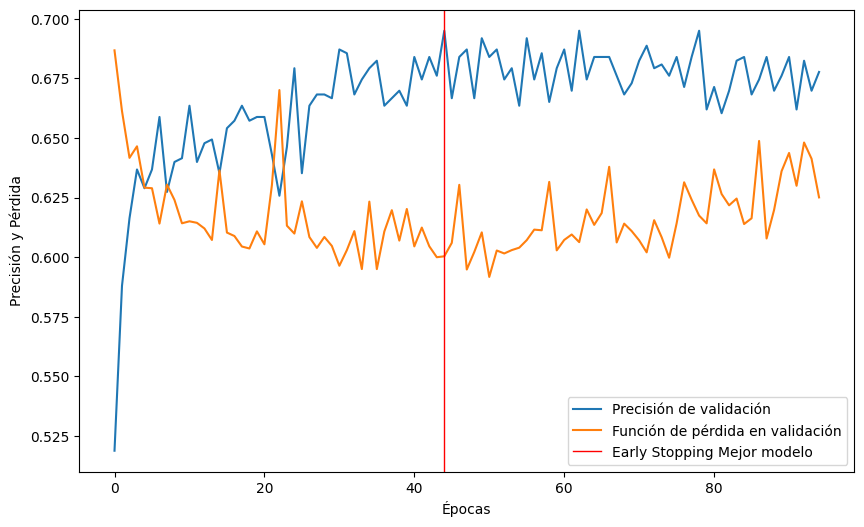

In [99]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.plot(history.history['val_loss'], label= 'Función de pérdida en validación')
plt.axvline(x=np.argmax(history.history['val_accuracy']), color='r', linestyle='-', linewidth=1, label='Early Stopping Mejor modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión y Pérdida')
plt.legend()
plt.show()

In [100]:
# Testeo, predicción y evaluación del modelo
test_loss, test_acc = model_multi_hot_LSTM.evaluate(X_test_encoded, y_test)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7090 - loss: 0.5335
Test Accuracy: 0.700628936290741
Test Loss: 0.545364260673523


**El modelo con arquitectura LSTM y codificación Multi-hot clasifica correctamente el 70% - 70.9% de los ejemplos de prueba.**

**E4:** Repite el ejercicio anterior, pero utilizando *embedding* de 16 dimensiones sobre la codificación *integer*. ¿Mejoran los resultados? ¿por qué? ¿Ayuda activar la opción *mask_zero* de la capa de embedding? ¿por qué?

**Los resultados mejoran considerablemente dado que la construcción de los embeddings permite que los péptidos se representen mediante vectores densos(16-d) que contienen mucha más información semántica de los distintos aminoácidos y las distintas relaciones entre ellos.**
**Haciendo esto así, facilitamos a la red la capturación de esta información fundamental de contexto a nivel de embeddings que puede ayudar en gran medida a entender la semántica de los distintos aminoácidos.**

**Por supuesto que ayuda activar la opción dado que esos ceros realmente no existen y si, se mantienen durante el entrenamiento, pueden crear confusión a la red y hacer que está no aprenda y no funcione como es debido.**

In [218]:
vocab = vectorizer.get_vocabulary()  
vocab_size = len(vocab)
print(f"Vocab size Integer codification: {vocab_size}")

Vocab size Integer codification: 27


**IMPORTANTE: Definimos la capa de embedding con la cantidad de tokens distintos que tiene el vocabulario y con la dimensión que queremos que tengan los embeddings asociados a cada token, en este caso trabajamos con embeddings de 16-d.**

In [113]:
model_int_LSTM_with_embedding = Sequential([ 
    layers.Input(shape=(max_len,)),  # Longitud de las secuencias de entrada
    Embedding(input_dim=vocab_size, output_dim=16, mask_zero=True),  # Capa de embedding con 16 dimensiones e ignoración de ceros del padding
    Bidirectional(LSTM(50, return_sequences=False)),  # LSTM bidireccional con 50 células que devuelve solamente la última salida (h_t)
    Dense(64, activation='relu'),  # Capa oculta con 64 neuronas
    Dense(1, activation='sigmoid')  
])

model_int_LSTM_with_embedding.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 101, 16)        │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 100)            │        26,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,761 (131.88 KB)

 Trainable params: 33,761 (131.88 KB)

 Non-trainable params: 0 (0.00 B)

In [114]:
# Obtención del 20% de los datos de entrenamiento para validación del modelo durante el proceso de entrenamiento
X_train_f, X_val_f, y_train_f, y_val_f = train_test_split(np.array(X_train_padded), y_train, test_size=0.2, random_state=2025, stratify=y_train)

# Conversión de las etiquetas a arrays de numpy para su uso en la red neuronal
y_train_f = np.array(y_train_f)
y_val_f = np.array(y_val_f)
y_test = np.array(y_test)

In [ ]:
# Definimos un earling stopping para detener el entrenamiento de los modelos cuando ya no mejoren la precisión de la validación
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Métrica a monitorear 
    patience=75,  # Número de epochs sin mejora antes de parar
    min_delta=0.00001,  # Pequeña mejora mínima requerida
    restore_best_weights=True,  # Restaura los mejores pesos en lugar de los últimos
    verbose=1  # Muestra mensaje en la consola con la época que contiene los mejores pesos
)

In [116]:
model_int_LSTM_with_embedding.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model_int_LSTM_with_embedding.fit(X_train_f, y_train_f, epochs=200, batch_size=64, validation_data=(X_val_f, y_val_f), callbacks=[early_stopping])

Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.5898 - loss: 0.6811 - val_accuracy: 0.7358 - val_loss: 0.5489
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7614 - loss: 0.5328 - val_accuracy: 0.7704 - val_loss: 0.4875
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7904 - loss: 0.4680 - val_accuracy: 0.7846 - val_loss: 0.4612
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7876 - loss: 0.4579 - val_accuracy: 0.8050 - val_loss: 0.4387
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8079 - loss: 0.4334 - val_accuracy: 0.8066 - val_loss: 0.4436
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8023 - loss: 0.4527 - val_accuracy: 0.7987 - val_loss: 0.4338
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8216 - loss: 0.4098 - val_accuracy: 0.8082 - val_loss: 0.4337
Epoch 8/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8215 - loss: 0.3998 - val_accuracy: 0.

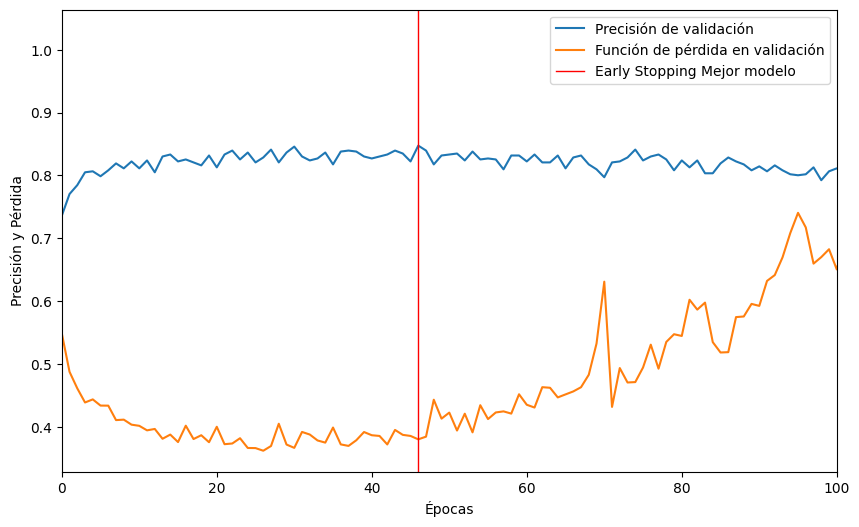

In [118]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.plot(history.history['val_loss'], label= 'Función de pérdida en validación')
plt.axvline(x=np.argmax(history.history['val_accuracy']), color='r', linestyle='-', linewidth=1, label='Early Stopping Mejor modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión y Pérdida')
plt.xlim(0, 100)
plt.legend()
plt.show()

In [119]:
test_loss, test_acc = model_int_LSTM_with_embedding.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8266 - loss: 0.4120
Test Accuracy: 0.8389937281608582
Test Loss: 0.40003255009651184


**El modelo con capa inicial de embedding de 16 dimensiones y arquitectura LSTM clasifica correctamente el 82.66% - 83.89% de los ejemplos de prueba.**

**E5:** Realiza varias repeticiones del entrenamiento de los modelos en los E2-3. ¿Obtienes siempre los mismos resultados? ¿por qué? ¿qué modelo presenta un comportamiento más estable?

**# Inciso: Entiendo que este ejercicio esta hecho para comparar los ejercicios 3 y 4 para ver las diferencias de los entrenamientos en los modelos con y sin embeddings** 

- **En ninguno de los dos modelos se obtiene siempre los mismos resultados debido a que hay partes del entrenamiento que presentan cierta aleatoriedad como la inicialización de los pesos o la elección de las distintas muestras de los datos para el entrenamiento**

- **Los modelos con embeddings presentan un comportamiento más estable al repetir los entrenamientos, porque las representaciones aprendidas por la capa de Embedding ayudan a reducir la aleatoriedad en la convergencia del modelo.**

- **Los modelos sin embeddings tienden a ser más inestables, ya que la LSTM debe aprender directamente a interpretar los enteros sin una representación previa, lo que depende más de la inicialización aleatoria de pesos.**


--- 

**E6:** Representa en un plano 2D los diferentes AAs sobre espacio generados por el embedding. ¿Pon un ejemplo de dos AAs con una funcionalidad muy similar? ¿qué AAs parecen tener un comportamiento diferente al resto?

**Ejemplos de aminoácidos con funcionalidades similares serían: W y O , F y R ya que aparecen muy cerca en el espacio. Los aminoácidos que parecen tener un comportamiento diferente serían C y, sobre todo, B y X ya que son representados en el espacio en zonas alejadas al clúster donde se encuentran todos los demás aminoácidos.** 

In [120]:
# Extraer el vocabulario real usado por TextVectorization
vocab = vectorizer.get_vocabulary()  # Obtener la lista de tokens en el orden correcto
vocab_size = len(vocab)  # Número de tokens únicos aprendidos

print(f"Vocabulario utilizado por el modelo: {vocab}")
print(f"Número total de tokens: {vocab_size}")

Vocabulario utilizado por el modelo: ['', '[UNK]', np.str_('K'), np.str_('L'), np.str_('G'), np.str_('A'), np.str_('R'), np.str_('S'), np.str_('V'), np.str_('I'), np.str_('C'), np.str_('E'), np.str_('T'), np.str_('P'), np.str_('N'), np.str_('F'), np.str_('D'), np.str_('Q'), np.str_('Y'), np.str_('M'), np.str_('H'), np.str_('W'), np.str_('X'), np.str_('U'), np.str_('O'), np.str_('Z'), np.str_('B')]
Número total de tokens: 27


In [134]:
embedding_weights = model_int_LSTM_with_embedding.layers[0].get_weights()[0]
print("Dimensiones reales de los embeddings:", embedding_weights.shape)

Dimensiones reales de los embeddings: (27, 16)


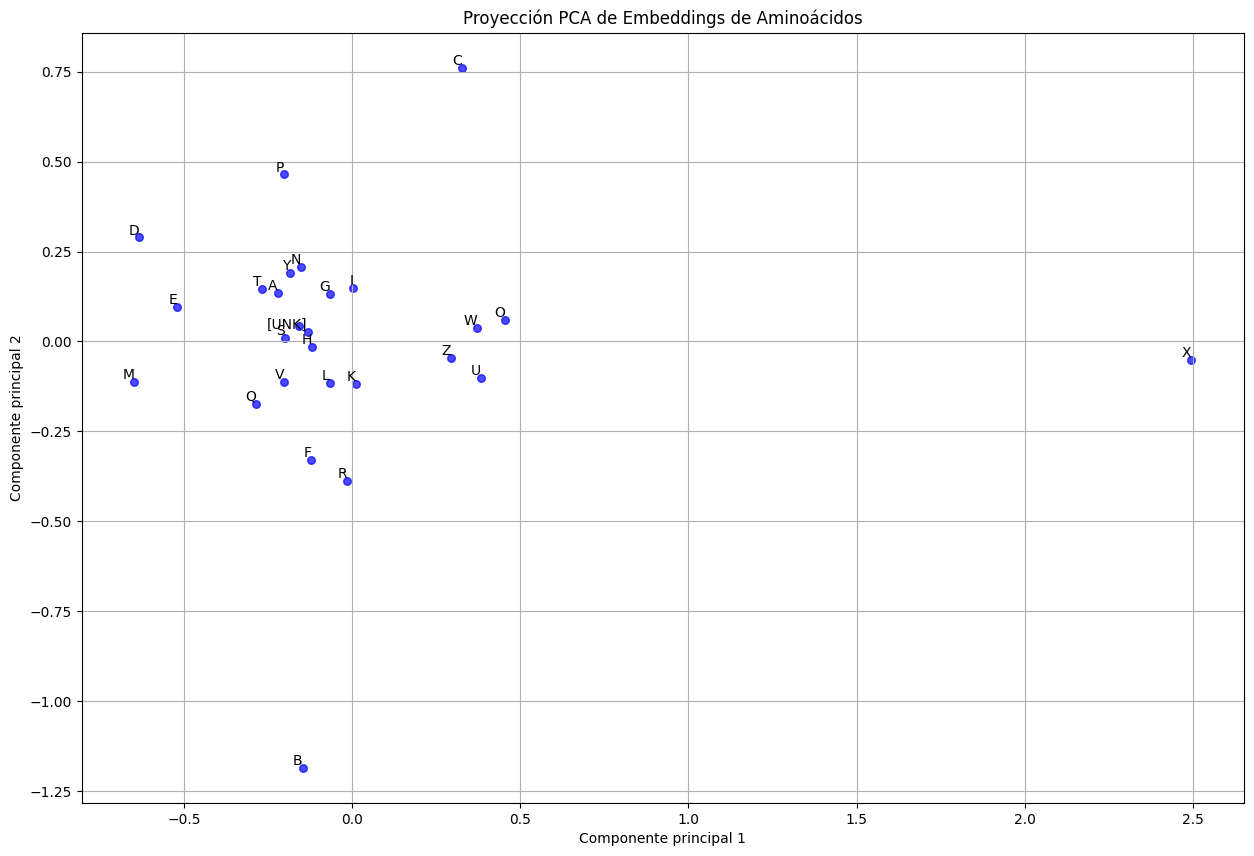

In [144]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Extraer la matriz de embeddings
embedding_layer = model_int_LSTM_with_embedding.layers[0]  # La segunda capa es el embedding
embedding_weights = embedding_layer.get_weights()[0]  # Obtener los pesos (matriz de embeddings)


# Reducimos a 2D con PCA realizando la proyección de los embeddings de cada aminoácido
pca = PCA(n_components=2)
embedding_2D = pca.fit_transform(embedding_weights)

# Lista de aminoácidos/tokens distintos
amino_acids = vectorizer.get_vocabulary()

# Graficamos
plt.figure(figsize=(15, 10))
plt.scatter(embedding_2D[:,0], embedding_2D[:,1], marker='o', s=30, alpha=0.7, c='blue')

# Anotamos cada aminoácido
for i, aa in enumerate(amino_acids):
    plt.text(embedding_2D[i, 0], embedding_2D[i, 1], aa, fontsize=10, ha='right', va='bottom')

plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.title("Proyección PCA de Embeddings de Aminoácidos")
plt.grid()
plt.show()


### **Sesión 3/3: Transformer**

In [156]:
from tensorflow.keras.layers import Layer, Embedding, Dense, MultiHeadAttention, LayerNormalization, Dropout, GlobalMaxPooling1D, Input
from tensorflow.keras.models import Model

**E1:** Implementa la clase MyTransformerEncoder según el esquema descrito anteriormente.

**E2:** Construye un clasificador a partir de MyTransformerEncoder. Para ello aplica una capa de [Embedding](https://keras.io/api/layers/core_layers/embedding/) antes de pasar los datos a MyTransfomerEncoder, luego aplica un [GlobalMaxPooling1D](https://keras.io/api/layers/pooling_layers/global_max_pooling1d/) a la salida y una capa final de activación sigmoide.


**Clase con la arquitectura del Transformer, se definen: las múltiples cabezas de atención que identificarán distintos patrones en las secuencias a partir del mecanismo de atención, las normalizaciones a realizar(se utilizará el Dropout), la proyección densa dentro del propio transformer para la detección de patrones más complejos y un dropout para mantener en todo moemnto un modelo que no se sobreajuste y que generalize correctamente.**

In [ ]:
class MyTransformerEncoder(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1, **kwargs):
        super(MyTransformerEncoder, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.dense_proj = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.dropout = tf.keras.layers.Dropout(dropout_rate)



    # Con el método call definimos como se va procesando la entrada, proveniente en este caso de la capa de embedding que definiremos después, capa por capa hasta llegar a la salida final del transformer
    def call(self, inputs, mask=None):
        attn_output = self.attention(inputs, inputs, attention_mask=mask)
        attn_output = self.dropout(attn_output)
        out1 = self.norm1(inputs + attn_output)  # Residual connection

        dense_output = self.dense_proj(out1)
        dense_output = self.dropout(dense_output)
        return self.norm2(out1 + dense_output)  # Residual connection


    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.attention.key_dim,
            "num_heads": self.attention.num_heads,
            "ff_dim": self.dense_proj.layers[0].units,
        })
        return config

**Construcción del primer modelo clasificador:**

In [177]:
# Construcción del modelo clasificador
vocab_size = len(vocab) # Número de aminoácidos/tokens únicos
max_len = 101  # Longitud máxima de secuencia
embed_dim = 16  # Tamaño del embedding
num_heads = 4  # Número de cabezales de atención
ff_dim = 32  # Dimensión de la proyección densa

inputs = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embed_dim)(inputs)
transformer_encoder = MyTransformerEncoder(embed_dim, num_heads, ff_dim)(embedding_layer)
pooling = GlobalMaxPooling1D()(transformer_encoder)
outputs = Dense(1, activation='sigmoid')(pooling)

**GlobalMaxPooling1D en este caso tiene como objetivo reducir la dimensionalidad de la salida del Transformer Encoder, extrayendo la característica más importante de cada canal de la representación generada.**

- El Transformer produce una salida de forma (batch_size, seq_length, embedding_dim), es decir, una representación por cada token de la secuencia.

- GlobalMaxPooling1D reduce esto a (batch_size, embedding_dim), lo que facilita la clasificación final.

**E3:** Carga el dataset de los péptidos y entrena el codificador completo del E2 y evalúa su precisión.

In [178]:
# Definimos un earling stopping para detener el entrenamiento de los modelos cuando ya no mejoren la precisión de la validación
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Métrica a monitorear 
    patience=80,  # Número de epochs sin mejora antes de parar
    min_delta=0.0001,  # Pequeña mejora mínima requerida
    restore_best_weights=True,  # Restaura los mejores pesos en lugar de los últimos
    verbose=1  # Muestra mensaje en la consola con la época que contiene los mejores pesos
)

**Compilación y entrenamiento del transformer:**

In [179]:
transformer1 = Model(inputs, outputs)
transformer1.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
transformer1.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_10 (Embedding)        │ (None, 101, 16)        │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_transformer_encoder_6        │ (None, 101, 16)        │         5,440 │
│ (MyTransformerEncoder)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ (None, 16)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,889 (23.00 KB)

 Trainable params: 5,889 (23.00 KB)

 Non-trainable params: 0 (0.00 B)

In [180]:
history = transformer1.fit(X_train_f, y_train_f, epochs=200, batch_size=32, validation_data=(X_val_f, y_val_f), callbacks=[early_stopping])

Epoch 1/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5849 - loss: 0.6768 - val_accuracy: 0.7075 - val_loss: 0.5657
Epoch 2/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7342 - loss: 0.5534 - val_accuracy: 0.7248 - val_loss: 0.5539
Epoch 3/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7456 - loss: 0.5258 - val_accuracy: 0.6965 - val_loss: 0.5660
Epoch 4/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7580 - loss: 0.5149 - val_accuracy: 0.7689 - val_loss: 0.5104
Epoch 5/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7728 - loss: 0.4896 - val_accuracy: 0.7799 - val_loss: 0.4917
Epoch 6/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7806 - loss: 0.4687 - val_accuracy: 0.7720 - val_loss: 0.4798
Epoch 7/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7932 - loss: 0.4517 - val_accuracy: 0.7704 - val_loss: 0.4866
Epoch 8/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7678 - loss: 0.4859 - val_accuracy: 0.

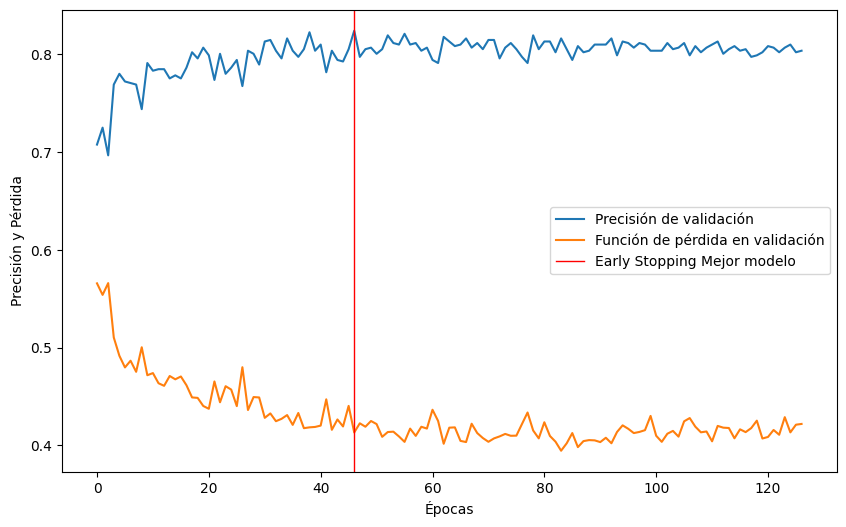

In [181]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.plot(history.history['val_loss'], label= 'Función de pérdida en validación')
plt.axvline(x=np.argmax(history.history['val_accuracy']), color='r', linestyle='-', linewidth=1, label='Early Stopping Mejor modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión y Pérdida')
plt.legend()
plt.show()

**Testeo del modelo mediante el conjunto de prueba:**

In [182]:
test_loss, test_acc = transformer1.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

# Guardamos el modelo entrenado
transformer1.save('../models/transformer1.h5')

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8148 - loss: 0.4191


Test Accuracy: 0.8138364553451538
Test Loss: 0.422162801027298


**E4:** Implementa la clase MyPositionEmbedding según el esquema descrito anteriormente.


In [203]:
# Capa de Embedding Posicional + Contextual mediante una clase

from keras.saving import register_keras_serializable

@register_keras_serializable()
class MyPositionalEmbedding(Layer):
    def __init__(self, vocab_size, embed_dim, max_len, **kwargs):
        super().__init__(**kwargs)                                                             # Matriz de embeddings para los tokens y posiciones
        self.token_embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim) # Embedding para los tokens: (27, 16) -> 27 aminoácidos/tokens distintos y 16 dimensiones
        self.position_embedding = Embedding(input_dim=max_len, output_dim=embed_dim) # Embedding para las posiciones: (101, 16) -> 101 posiciones distintas y 16 dimensiones
    
    def call(self, inputs):
        positions = tf.range(start=0, limit=tf.shape(inputs)[-1], delta=1)
        positions = self.position_embedding(positions)
        token_embeddings = self.token_embedding(inputs)
        return token_embeddings + positions
    
    def get_config(self):
        config = super().get_config()
        config.update({"vocab_size": self.token_embedding.input_dim,
                       "embed_dim": self.token_embedding.output_dim,
                       "max_len": max_len})
        return config

    def compute_mask(self, inputs, mask=None):
        return self.token_embedding.compute_mask(inputs, mask)

**E5:** Construye un clasificador sustituyendo la capa de Embedding por la clase implementada en E4. Entrena y evalúa el nuevo modelo. ¿Qué nueva información se ha añadidio al clasificador? ¿ha mejorado los resultados? ¿por qué?

**Se añade la información de la posición en la que se encuentran los distintos aminoácidos/tokens en la secuencia, esta información ya no es codificada por el cáracter secuencial de modelo debido a que este tipo de arquitectura se centra solo en el mecanismo de atención, por tanto, esta capa agrega información posicional para que el modelo distinga el orden de los aminoácidos.**

**No parece que se produzca una mejora considerable en los resultados, creo que se debe a que, en este problema, no es tan importante la posición de la secuencia en la que se encuentran los aminoácidos, creo que se le da mucha más importancia a las relaciones entre aminoácidos y a los patrones que la red consigue captar gracias a los embeddings contextuales.**

**Construcción del segundo modelo clasificador haciendo uso de las dos clases generadas: Capa de Embedding Posicional + Contextual y la capa de Transformer Encoder**

In [204]:
vocab_size = len(vocab) # Número de aminoácidos/tokens únicos
max_len = 101  # Longitud máxima de secuencia
embed_dim = 16  # Tamaño del embedding
num_heads = 4  # Número de cabezas de atención
ff_dim = 32  # Dimensión de la proyección densa


inputs = Input(shape=(max_len,))
embedding_layer = MyPositionalEmbedding(vocab_size, embed_dim, max_len)(inputs)
transformer_encoder = MyTransformerEncoder(embed_dim, num_heads, ff_dim)(embedding_layer)
pooling = GlobalMaxPooling1D()(transformer_encoder)
outputs = Dense(1, activation='sigmoid')(pooling)

**Compilación y entrenamiento del Transformer:**

In [205]:
transformer_ctx_pos_emb = Model(inputs, outputs)
transformer_ctx_pos_emb.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
transformer_ctx_pos_emb.summary()


Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_positional_embedding_4       │ (None, 101, 16)        │         2,048 │
│ (MyPositionalEmbedding)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_transformer_encoder_11       │ (None, 101, 16)        │         5,440 │
│ (MyTransformerEncoder)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_9          │ (None, 16)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,505 (29.32 KB)

 Trainable params: 7,505 (29.32 KB)

 Non-trainable params: 0 (0.00 B)

In [206]:
history = transformer_ctx_pos_emb.fit(X_train_f, y_train_f, epochs=200, batch_size=32, validation_data=(X_val_f, y_val_f), callbacks=[early_stopping])

Epoch 1/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5588 - loss: 0.7016 - val_accuracy: 0.7154 - val_loss: 0.5698
Epoch 2/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7628 - loss: 0.5348 - val_accuracy: 0.7642 - val_loss: 0.5025
Epoch 3/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7844 - loss: 0.4862 - val_accuracy: 0.7720 - val_loss: 0.4708
Epoch 4/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8027 - loss: 0.4445 - val_accuracy: 0.7830 - val_loss: 0.4548
Epoch 5/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8321 - loss: 0.4089 - val_accuracy: 0.7972 - val_loss: 0.4555
Epoch 6/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8232 - loss: 0.4034 - val_accuracy: 0.8050 - val_loss: 0.4387
Epoch 7/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8340 - loss: 0.3857 - val_accuracy: 0.7987 - val_loss: 0.4309
Epoch 8/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8426 - loss: 0.3767 - val_accuracy: 0.

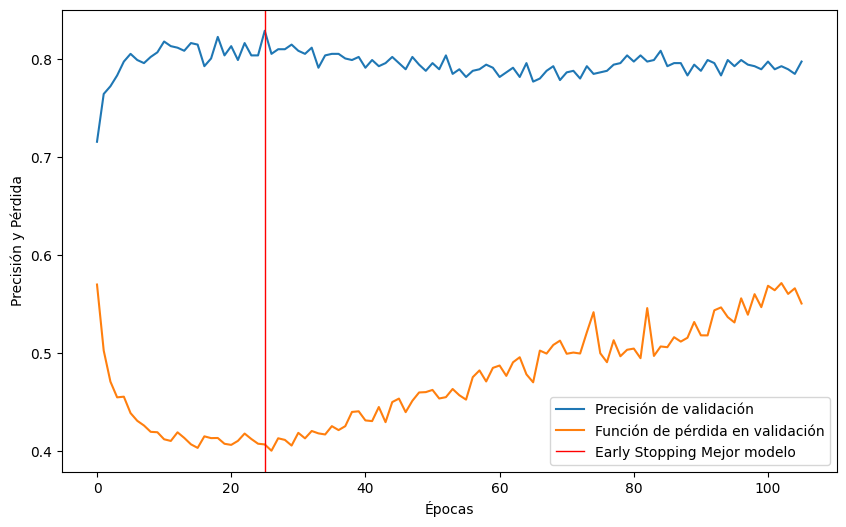

In [207]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.plot(history.history['val_loss'], label= 'Función de pérdida en validación')
plt.axvline(x=np.argmax(history.history['val_accuracy']), color='r', linestyle='-', linewidth=1, label='Early Stopping Mejor modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión y Pérdida')
plt.legend()
plt.show()

In [208]:
test_loss, test_acc = transformer_ctx_pos_emb.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

# Guardamos el modelo entrenado
transformer_ctx_pos_emb.save('../models/transformer_embed_contextuales_y_pos.h5')

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8237 - loss: 0.3733


Test Accuracy: 0.8138364553451538
Test Loss: 0.4019136130809784


**E6:** ¿Por qué parece que la mejora de utilizar la información posicional no es muy significativa? ¿a qué se podría deber?

**Como he contestado con anterioridad, creo que se debe al propio problema en sí ya que, no es tan importante la posición en la que se encuentran los aminoácidos sino las relaciones que establecen entre ellos.**

**Hay que tener en cuenta que algunas propiedades de los péptidos dependen más de la composición de los aminoácidos o de interacciones específicas entre ciertos residuos que de su posición en la secuencia.**


**E7:** Ajusta los hiperparámetros del modelo en E5 y el LSTM bidireccional del E4 de la Sesión 2 hasta obtener una configuración óptima para cada modelo. ¿Qué modelo consigue un mejor funcionamiento? ¿qué puedes decir sobre el entrenamiento de ambos modelos? 

**Parece que la LSTM bidireccional consigue obtener un mejor funcionamiento a la hora de resolver la tarea, obtiene un accuracy de validación del 86% mientras que el Transformer consigue un 83.33%.**

**Sobre el entrenamiento podemos decir que el Transformer se entrena mucho más rápido debido a que puede paralelizar el entrenamiento al poder procesar las secuencias de tokens completas mientras que la LSTM tiene que procesar los tokens de manera secuencial.**

**Ajuste de hiperparámetros del Transformer:**

In [216]:
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

In [211]:
# Definimos el modelo Transformer con hiperparámetros ajustables
def build_transformer_model(hp):
    inputs = Input(shape=(max_len,))
    embedding_layer = MyPositionalEmbedding(
        vocab_size, 
        hp.Choice('embed_dim', values=[16, 32]), 
        max_len
    )(inputs)
    
    transformer_encoder = MyTransformerEncoder(
        embed_dim=hp.Choice('embed_dim', values=[16, 32]),  
        num_heads=hp.Choice('num_heads', values=[2, 4, 6]), 
        ff_dim=hp.Int('ff_dim', min_value=32, max_value=64, step=32)
    )(embedding_layer)

    pooling = GlobalMaxPooling1D()(transformer_encoder)
    outputs = Dense(1, activation='sigmoid')(pooling)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    
    return model

# Configuramos el tuner
tuner_transformer = kt.Hyperband(
    build_transformer_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='tuner_results',
    project_name='transformer_tuning'
)


# Ejecutar búsqueda de hiperparámetros
tuner_transformer.search(X_train_f, y_train_f, epochs=50, validation_data=(X_val_f, y_val_f), callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)])

# Obtener mejores hiperparámetros
best_hps_transformer = tuner_transformer.get_best_hyperparameters()[0]
print("Mejores hiperparámetros Transformer:", best_hps_transformer.values)


Trial 52 Complete [00h 00m 23s]
val_accuracy: 0.8317610025405884

Best val_accuracy So Far: 0.8333333134651184
Total elapsed time: 00h 05m 03s
Mejores hiperparámetros Transformer: {'embed_dim': 32, 'num_heads': 6, 'ff_dim': 64, 'learning_rate': 0.001, 'tuner/epochs': 17, 'tuner/initial_epoch': 6, 'tuner/bracket': 3, 'tuner/round': 2, 'tuner/trial_id': '0035'}


**Ajuste de hiperparámetros del modelo LSTM bidireccional:**

In [212]:
# Definimos el modelo LSTM con hiperparámetros ajustables
def build_lstm_model(hp):
    model = Sequential([
        Embedding(
            input_dim=vocab_size, 
            output_dim=hp.Choice('embed_dim', values=[16, 32, 64]), 
            mask_zero=True
        ),
        Bidirectional(LSTM(
            units=hp.Int('lstm_units', min_value=32, max_value=128, step=32), 
            return_sequences=False
        )),
        Dense(hp.Int('dense_units', min_value=32, max_value=64, step=32), activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model



# Configuramos el tuner
tuner_lstm = kt.Hyperband(
    build_lstm_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='tuner_results',
    project_name='lstm_tuning'
)

# Ejecutar búsqueda de hiperparámetros
tuner_lstm.search(X_train_f, y_train_f, epochs=50, validation_data=(X_val_f, y_val_f), callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)])

# Obtener mejores hiperparámetros
best_hps_lstm = tuner_lstm.get_best_hyperparameters()[0]
print("Mejores hiperparámetros LSTM:", best_hps_lstm.values)

Trial 89 Complete [00h 04m 21s]
val_accuracy: 0.8537735939025879

Best val_accuracy So Far: 0.8600628972053528
Total elapsed time: 05h 50m 16s
Mejores hiperparámetros LSTM: {'embed_dim': 64, 'lstm_units': 128, 'dense_units': 64, 'learning_rate': 0.001, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 3, 'tuner/round': 3, 'tuner/trial_id': '0048'}
